In [1]:
from CT_COVID_Preprocess import CTCOVIDDataset
from model_tools import validation, train, load_model_checkpoint
from eval_tools import VGG19_CAM
from eval_tools import plot_train_val, test, display_FP_FN, get_confusion_matrix, plot_ROCAUC_curve, showCAM
from custom_model import CNN_COVIDCT
import torch
import torchvision
import torch.optim as optim
from monai.transforms import Compose, LoadPNG, AddChannel, ScaleIntensity, ToTensor, RandRotate, RandFlip, RandZoom, Resize, RandGaussianNoise
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
from collections import OrderedDict
from torchvision import transforms

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
dirCOVID = 'C:/Users/rrsoo/AdvancedStuff/Medical_AI/Classifier/Images-processed-new/CT_COVID'
dirNonCOVID = 'C:/Users/rrsoo/AdvancedStuff/Medical_AI/Classifier/Images-processed-new/CT_NonCOVID'

In [4]:
train_transforms = transforms.Compose([
        LoadPNG(),
        AddChannel(),
        ScaleIntensity(),
        RandRotate(degrees=15, prob=0.5),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        RandGaussianNoise(prob = 0.5),
        Resize(spatial_size=(224, 224)),
        ToTensor()
    ])
   

val_transforms = transforms.Compose([
    LoadPNG(),
    AddChannel(),
    ScaleIntensity(),
    ToTensor()
])

In [5]:
BATCH_SIZE = 32
ORIG_RES = False

train_ds = CTCOVIDDataset(dirCOVID, dirNonCOVID, transforms = train_transforms, data = 'train', orig_res = ORIG_RES)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

val_ds = CTCOVIDDataset(dirCOVID, dirNonCOVID, transforms = val_transforms, data = 'val', orig_res = ORIG_RES)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True)

test_ds = CTCOVIDDataset(dirCOVID, dirNonCOVID, transforms = val_transforms, data = 'test', orig_res = ORIG_RES)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 346/346 [00:01<00:00, 332.30it/s]


In [6]:
model_name = 'vgg16' #changeable
PRETRAINED = True #changeable

model = None #Don't touch

if model_name == 'vgg16':
    model = torchvision.models.vgg16(pretrained = PRETRAINED).to(device)
    
    if PRETRAINED:
        for param in model.parameters():
            param.requires_grad = False
            
    layers_vgg16 = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(25088, 512)),
            ('activation1', nn.ReLU()),
            ('dropout1', nn.Dropout()),
            ('fc2', nn.Linear(512, 256)),
            ('activation2', nn.ReLU()),
            ('dropout2', nn.Dropout()),
            ('fc3', nn.Linear(256, 128)),
            ('activation3', nn.ReLU()),
            ('dropout3', nn.Dropout()),
            ('fc4', nn.Linear(128, 2)),
            ('out', nn.Sigmoid())

        ])).to(device)
    model.classifier = layers_vgg16

assert(model is not None)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [7]:
epochs = 40
optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-3, max_lr=1e-2, cycle_momentum=False)
criterion = nn.CrossEntropyLoss()
#plot_train_loss, plot_val_loss, plot_train_acc, plot_val_acc
history = train(model, train_loader, val_loader, optimizer, criterion, epochs, device = device, scheduler = scheduler)

  0%|          | 0/19 [00:00<?, ?it/s]

Training Loss: 13.141191899776459
Training Accuracy: 0.5462184873949579
Validation Loss: 2.07830947637558
Validation Accuracy: 0.5405405405405406


  0%|          | 0/19 [00:00<?, ?it/s]

Training Loss: 13.031852424144745
Training Accuracy: 0.5697478991596638
Validation Loss: 2.025939702987671
Validation Accuracy: 0.527027027027027


  0%|          | 0/19 [00:00<?, ?it/s]

Training Loss: 12.359479486942291
Training Accuracy: 0.6235294117647059
Validation Loss: 1.9654698967933655
Validation Accuracy: 0.527027027027027


  0%|          | 0/19 [00:00<?, ?it/s]

Training Loss: 11.648595213890076
Training Accuracy: 0.6621848739495798
Validation Loss: 1.729421466588974
Validation Accuracy: 0.7972972972972973


  0%|          | 0/19 [00:00<?, ?it/s]

Training Loss: 10.50377443432808
Training Accuracy: 0.7563025210084033
Validation Loss: 1.8555910885334015
Validation Accuracy: 0.6891891891891891


  0%|          | 0/19 [00:00<?, ?it/s]

Training Loss: 10.41626313328743
Training Accuracy: 0.746218487394958
Validation Loss: 1.6419893503189087
Validation Accuracy: 0.7297297297297297


  0%|          | 0/19 [00:00<?, ?it/s]

Training Loss: 9.824998170137405
Training Accuracy: 0.7831932773109244
Validation Loss: 1.5550594627857208
Validation Accuracy: 0.8243243243243243


  0%|          | 0/19 [00:00<?, ?it/s]

Training Loss: 9.472046971321106
Training Accuracy: 0.8084033613445378
Validation Loss: 1.5928544998168945
Validation Accuracy: 0.8108108108108109


  0%|          | 0/19 [00:00<?, ?it/s]

Training Loss: 9.464837193489075
Training Accuracy: 0.8117647058823529
Validation Loss: 1.3752563893795013
Validation Accuracy: 0.8108108108108109


  0%|          | 0/19 [00:00<?, ?it/s]

Training Loss: 9.331190168857574
Training Accuracy: 0.8151260504201681
Validation Loss: 1.5002613067626953
Validation Accuracy: 0.8243243243243243


  0%|          | 0/19 [00:00<?, ?it/s]

Training Loss: 8.586516618728638
Training Accuracy: 0.8588235294117647
Validation Loss: 1.243721604347229
Validation Accuracy: 0.8648648648648649


  0%|          | 0/19 [00:00<?, ?it/s]

Training Loss: 8.327151209115982
Training Accuracy: 0.8823529411764706
Validation Loss: 1.3713842332363129
Validation Accuracy: 0.8648648648648649


  0%|          | 0/19 [00:00<?, ?it/s]

Training Loss: 8.12370851635933
Training Accuracy: 0.8890756302521008
Validation Loss: 1.5266180038452148
Validation Accuracy: 0.8108108108108109


  0%|          | 0/19 [00:00<?, ?it/s]

Training Loss: 8.548732042312622
Training Accuracy: 0.8470588235294118
Validation Loss: 1.2342082858085632
Validation Accuracy: 0.8918918918918919


  0%|          | 0/19 [00:00<?, ?it/s]

Training Loss: 7.966724395751953
Training Accuracy: 0.8873949579831932
Validation Loss: 1.3181159794330597
Validation Accuracy: 0.8648648648648649


  0%|          | 0/19 [00:00<?, ?it/s]

Training Loss: 7.956470161676407
Training Accuracy: 0.9008403361344538
Validation Loss: 1.1998901963233948
Validation Accuracy: 0.8918918918918919


  0%|          | 0/19 [00:00<?, ?it/s]

Training Loss: 7.669515132904053
Training Accuracy: 0.9126050420168067
Validation Loss: 1.271812379360199
Validation Accuracy: 0.918918918918919


  0%|          | 0/19 [00:00<?, ?it/s]

Training Loss: 8.222752004861832
Training Accuracy: 0.8789915966386554
Validation Loss: 1.2376285195350647
Validation Accuracy: 0.8648648648648649


  0%|          | 0/19 [00:00<?, ?it/s]

Training Loss: 8.420585334300995
Training Accuracy: 0.8621848739495799
Validation Loss: 1.4003706574440002
Validation Accuracy: 0.8648648648648649


  0%|          | 0/19 [00:00<?, ?it/s]

Training Loss: 8.277501821517944
Training Accuracy: 0.8739495798319328
Validation Loss: 1.242676019668579
Validation Accuracy: 0.9054054054054054


  0%|          | 0/19 [00:00<?, ?it/s]

Training Loss: 7.359542936086655
Training Accuracy: 0.9277310924369748
Validation Loss: 1.185342788696289
Validation Accuracy: 0.8918918918918919


  0%|          | 0/19 [00:00<?, ?it/s]

Training Loss: 7.076036632061005
Training Accuracy: 0.9411764705882353
Validation Loss: 1.26828333735466
Validation Accuracy: 0.9054054054054054


  0%|          | 0/19 [00:00<?, ?it/s]

Training Loss: 7.219426721334457
Training Accuracy: 0.9361344537815126
Validation Loss: 1.2594977915287018
Validation Accuracy: 0.8918918918918919


  0%|          | 0/19 [00:00<?, ?it/s]

Training Loss: 7.718283534049988
Training Accuracy: 0.9025210084033614
Validation Loss: 1.1660305559635162
Validation Accuracy: 0.8918918918918919


  0%|          | 0/19 [00:00<?, ?it/s]

Training Loss: 6.989004224538803
Training Accuracy: 0.9445378151260504
Validation Loss: 1.1148005425930023
Validation Accuracy: 0.9324324324324325


  0%|          | 0/19 [00:00<?, ?it/s]

Training Loss: 6.995737850666046
Training Accuracy: 0.946218487394958
Validation Loss: 1.2172255516052246
Validation Accuracy: 0.918918918918919


  0%|          | 0/19 [00:00<?, ?it/s]

Training Loss: 7.291665881872177
Training Accuracy: 0.9310924369747899
Validation Loss: 1.1041294932365417
Validation Accuracy: 0.9324324324324325


  0%|          | 0/19 [00:00<?, ?it/s]

Training Loss: 7.258395314216614
Training Accuracy: 0.9327731092436975
Validation Loss: 1.308337241411209
Validation Accuracy: 0.8918918918918919


  0%|          | 0/19 [00:00<?, ?it/s]

Training Loss: 7.530590832233429
Training Accuracy: 0.9159663865546218
Validation Loss: 1.2128616869449615
Validation Accuracy: 0.9054054054054054


  0%|          | 0/19 [00:00<?, ?it/s]

Training Loss: 7.028969168663025
Training Accuracy: 0.9428571428571428
Validation Loss: 1.1194079220294952
Validation Accuracy: 0.918918918918919


  0%|          | 0/19 [00:00<?, ?it/s]

Training Loss: 7.310421705245972
Training Accuracy: 0.9310924369747899
Validation Loss: 1.5756721496582031
Validation Accuracy: 0.7702702702702703


  0%|          | 0/19 [00:00<?, ?it/s]

Training Loss: 7.908705949783325
Training Accuracy: 0.8907563025210085
Validation Loss: 1.2174041271209717
Validation Accuracy: 0.8918918918918919


  0%|          | 0/19 [00:00<?, ?it/s]

Training Loss: 8.488509356975555
Training Accuracy: 0.8672268907563025
Validation Loss: 1.4370496273040771
Validation Accuracy: 0.8108108108108109


  0%|          | 0/19 [00:00<?, ?it/s]

Training Loss: 7.865685254335403
Training Accuracy: 0.892436974789916
Validation Loss: 1.2447011172771454
Validation Accuracy: 0.8918918918918919


  0%|          | 0/19 [00:00<?, ?it/s]

Training Loss: 7.360965251922607
Training Accuracy: 0.9243697478991597
Validation Loss: 1.2254701852798462
Validation Accuracy: 0.8918918918918919


  0%|          | 0/19 [00:00<?, ?it/s]

Training Loss: 7.312741935253143
Training Accuracy: 0.9277310924369748
Validation Loss: 1.102856993675232
Validation Accuracy: 0.9324324324324325


  0%|          | 0/19 [00:00<?, ?it/s]

Training Loss: 6.982377529144287
Training Accuracy: 0.9495798319327731
Validation Loss: 1.269823044538498
Validation Accuracy: 0.8918918918918919


  0%|          | 0/19 [00:00<?, ?it/s]

Training Loss: 7.593986511230469
Training Accuracy: 0.9193277310924369
Validation Loss: 1.1950437724590302
Validation Accuracy: 0.918918918918919


  0%|          | 0/19 [00:00<?, ?it/s]

Training Loss: 7.911168873310089
Training Accuracy: 0.8907563025210085
Validation Loss: 1.1828024983406067
Validation Accuracy: 0.918918918918919


100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

Training Loss: 7.087698310613632
Training Accuracy: 0.9378151260504202
Validation Loss: 1.1905656158924103
Validation Accuracy: 0.8783783783783784


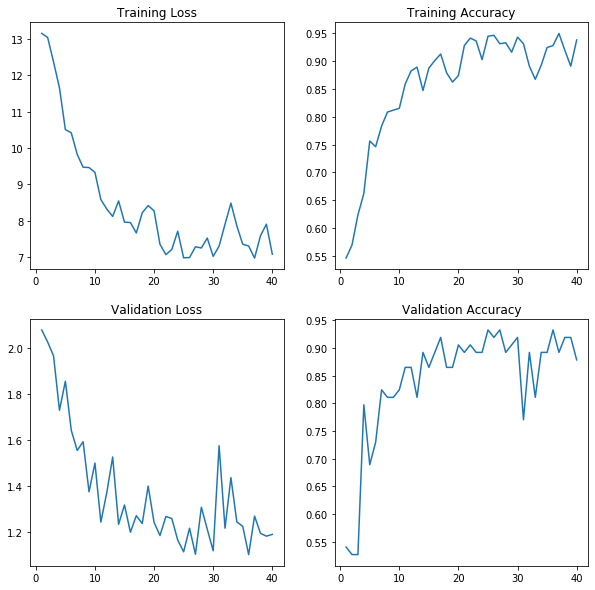

In [8]:
plot_train_val(history, epochs, (10, 10))

In [9]:
'''
model_dir = 'vgg16_B32_E20_lrcyclic.pth'

checkpoints = {
    'model' : model,
    'input_shape' : (224, 224, 3),
    'batch_size' : 32,
    'epochs' : 20,
    'train_acc' : 96.5,
    'val_acc' : 96,
    'state_dict' : model.state_dict()
}

torch.save(checkpoints, model_dir)
'''

"\nmodel_dir = 'vgg16_B32_E20_lrcyclic.pth'\n\ncheckpoints = {\n    'model' : model,\n    'input_shape' : (224, 224, 3),\n    'batch_size' : 32,\n    'epochs' : 20,\n    'train_acc' : 96.5,\n    'val_acc' : 96,\n    'state_dict' : model.state_dict()\n}\n\ntorch.save(checkpoints, model_dir)\n"